<a href="https://colab.research.google.com/github/jishnujp/US_senate_roll_call/blob/main/voteSummary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vote Summary

## Roll Call Vote 117th Congress - 1st Session
### **Subject**
On the Nomination (Confirmation: Tiffany P. Cunningham, of Illinois, to be United States Circuit Judge for the Federal Circuit.)

### Votes
- YEAs - 63
- NAYs - 33
- Not Voting - 4

link - https://www.senate.gov/legislative/LIS/roll_call_votes/vote1171/vote_117_1_00267.htm



## Scraping

In [1]:
## We have the xml link, which make scraping easier.
import pandas as pd
from bs4 import BeautifulSoup
from requests import get

link = "https://www.senate.gov/legislative/LIS/roll_call_votes/vote1171/vote_117_1_00267.xml"
members = BeautifulSoup(get(link).text,'xml').find('members')
votes = pd.DataFrame(columns = ['first_name','last_name','party','state','vote_cast'])
for i,m in enumerate(members.find_all('member')):
    votes.loc[i] = [m.first_name.text, m.last_name.text, m.party.text, m.state.text, m.vote_cast.text]
display(votes.head())
votes.to_csv('roll_call_votes.csv')
print("Shape of dataframe: ",votes.shape)
print("Ratio of rows to cols: ",votes.shape[0]/votes.shape[1])

,first_name,last_name,party,state,vote_cast
0,Tammy,Baldwin,D,WI,Yea
1,John,Barrasso,R,WY,Nay
2,Michael,Bennet,D,CO,Yea
3,Marsha,Blackburn,R,TN,Nay
4,Richard,Blumenthal,D,CT,Yea


Shape of dataframe:  (100, 5)
Ratio of rows to cols:  20.0


In [2]:
100/6

16.666666666666668

## Exploring

### Basic

In [3]:
party_name = {'R':'Republican','D':'Democrat','I':'Independent'}

summary = votes.groupby('party').vote_cast.value_counts().unstack().fillna(0).astype(int)
summary.index = [party_name[i] for i in summary.index]
votes_summary = summary.copy()

summary.insert(0,'Yea',summary.pop('Yea'))
summary.loc['Total'] = summary.sum()
summary['Total'] = summary.sum(axis = 1)
display(summary)

vote_cast,Yea,Nay,Not Voting,Total
Democrat,46,0,2,48
Independent,2,0,0,2
Republican,15,33,2,50
Total,63,33,4,100


In [4]:
# What is the votes ratio of Democrats' major decision to Republicans' major decision ?
maj_ratio = round(summary.loc['Democrat'][:-1].max()/summary.loc['Republican'][:-1].max(),2)
print(f"Votes ratio of Democrats' major decision to Republicans' major decision is {maj_ratio}")

Votes ratio of Democrats' major decision to Republicans' major decision is 1.39


In [5]:
# What is the highest absolute difference in percentage between yea and nay senators among the different parties?
print("---------Normalized Summary-----------")
summary_norm = summary.iloc[:,:-1].div(summary.Total,axis = 0)*100
summary_norm['y_n_diff'] = abs(summary_norm.Yea - summary_norm.Nay)
display(summary_norm.round(1))
R_diff,D_diff = summary_norm.loc['Republican'].y_n_diff, summary_norm.loc['Democrat'].y_n_diff
print(f"The difference in percentage between yea and nay among Republicans is {R_diff}")
print(f"The difference in percentage between yea and nay among Democrats is {round(D_diff,2)}")
print(f"highest absolute difference in percentage between yea and nay among the different parties is {round(max(R_diff,D_diff),2)}")

---------Normalized Summary-----------


vote_cast,Yea,Nay,Not Voting,y_n_diff
Democrat,95.8,0.0,4.2,95.8
Independent,100.0,0.0,0.0,100.0
Republican,30.0,66.0,4.0,36.0
Total,63.0,33.0,4.0,30.0


The difference in percentage between yea and nay among Republicans is 36.0
The difference in percentage between yea and nay among Democrats is 95.83
highest absolute difference in percentage between yea and nay among the different parties is 95.83


### State wise

In [6]:
# How many states have both Republican senators?                   ## RR
# How many states have both Democrat senators?                     ## DD
# How many states have both Republican and Democrat senators?      ## RD
# How many states voted all Yay?                                   ## YY
# How many states voted all Nay?                                   ## NN
# How many states had at least 1 non-voting senator?               ## NV

RR,DD,RD,YY,NN,NV = 0,0,0,0,0,0
for state,group in votes[['state','party','vote_cast']].groupby('state'):
    party,vote = set(group.party),set(group.vote_cast)
    
    ## ---------State wise senetor party counts----------
    if party == {'R'}:
        RR += 1
    elif party =={'D'}:
        DD += 1
    elif party == {'R','D'}:
        RD += 1
        
    ## ---------State wise vote counts--------
    if vote == {'Yea'}:
        YY +=1
    elif vote == {'Nay'}:
        NN += 1
    elif 'Not Voting' in vote:
        NV += 1
        
print(f"{RR} states have both Republican senators")
print(f"{DD} states have both Democrat senators")
print(f"{RD} states have both Republican and Democrat senators")
print(f"{YY} states voted all Yay")
print(f"{NN} states voted all Nay")
print(f"{NV} states had at least 1 non-voting senator")

22 states have both Republican senators
21 states have both Democrat senators
5 states have both Republican and Democrat senators
26 states voted all Yay
12 states voted all Nay
4 states had at least 1 non-voting senator


### Funny

In [7]:
# How many Senators have their names starting with W?
names = votes.copy()
names.insert(0,'name',names.first_name + " " + names.last_name)
names = names.drop(['first_name','last_name','party','state'],axis = 1)
display(names.loc[names.name.str.contains('W')].reset_index(drop = True))

# What's the total number of Yea votes from all senators whose name starts with "B"?
display(names.loc[(names.name.str.contains('B')) & (names.vote_cast == 'Yea')].reset_index(drop = True))

,name,vote_cast
0,Mark Warner,Yea
1,Raphael Warnock,Yea
2,Elizabeth Warren,Yea
3,Sheldon Whitehouse,Yea
4,Roger Wicker,Nay
5,Ron Wyden,Yea


,name,vote_cast
0,Tammy Baldwin,Yea
1,Michael Bennet,Yea
2,Richard Blumenthal,Yea
3,Sherrod Brown,Yea
4,Richard Burr,Yea
5,Ben Cardin,Yea
6,Bob Casey,Yea
7,Ben Lujan,Yea
8,Bernard Sanders,Yea
9,Brian Schatz,Yea


## Plots

### Heat map of party wise votes

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
sns.set(font_scale=1.4)
votes_summary.columns.name = ''
votes_summary = votes_summary.reindex(['Democrat','Republican','Independent'])
votes_summary = votes_summary[['Yea','Nay','Not Voting']]

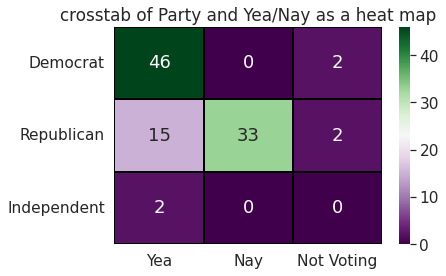

In [10]:
ax = plt.axes()
ax.set(title='crosstab of Party and Yea/Nay as a heat map')
hmap = sns.heatmap(votes_summary,cmap = 'PRGn',annot = True,linewidth=2,linecolor = 'black',
            annot_kws={'fontsize':18},ax = ax).get_figure()

hmap.savefig('heatmap.jpg',bbox_inches = 'tight')

### Barchart of party wise vote (stacked)

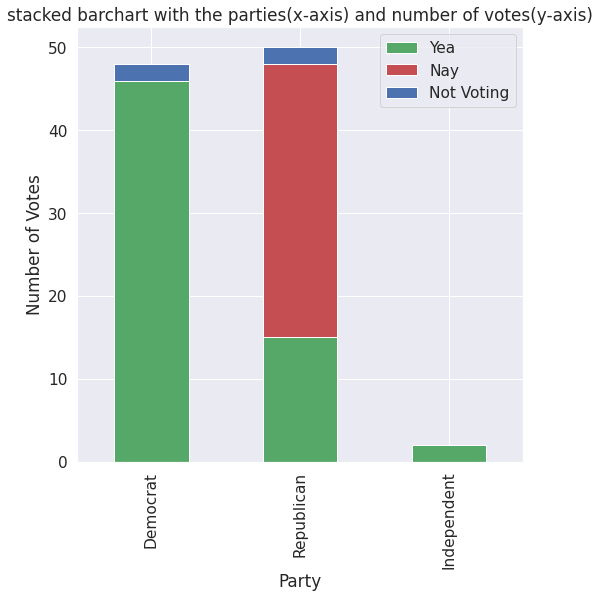

In [11]:
stacked = votes_summary.plot(kind = 'bar',stacked = True,color = ['g','r','b'],
                   figsize = (8,8),ylabel = 'Number of Votes',xlabel = 'Party',
                            title = "stacked barchart with the parties(x-axis) and number of votes(y-axis)").get_figure()
stacked.savefig('stacked_bar.jpg',bbox_inches = 'tight')

### Pie chart of Republican votes

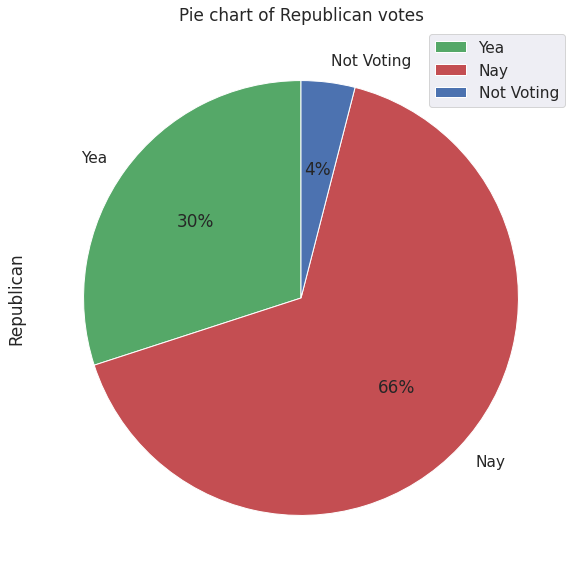

In [12]:
republican_pie = votes_summary.T.plot.pie(y = 'Republican',figsize = (10,10),startangle = 90,
                         autopct = "%1.0f%%",colors = ['g','r','b'],
                                         title = "Pie chart of Republican votes").get_figure()
republican_pie.savefig('republican_pie.jpg',bbox_inches = 'tight')

### State dominance of party (pie chart)

In [13]:
import numpy as  np
def func(pct, allvalues):
    absolute = pct / 100.* sum(allvalues)
    return "{:.0f}%\n({:.0f})".format(pct, absolute)

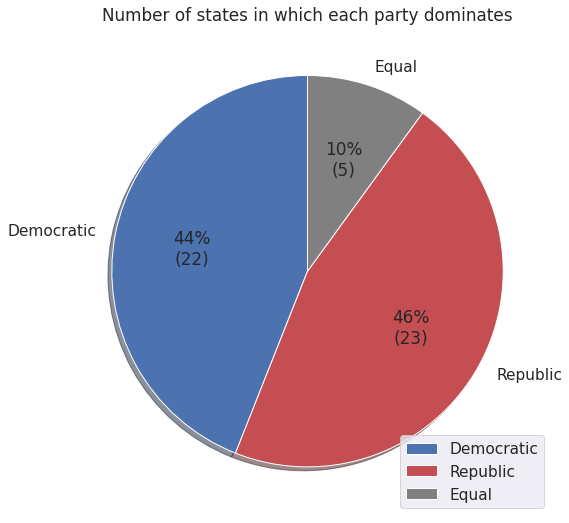

In [14]:
states_sum = votes.groupby('party').state.value_counts().unstack().fillna(0).astype(int).T
#states_sum = pd.DataFrame(columns = ['Democratic','Republic','Equal'])
eq = len(states_sum[states_sum.D == states_sum.R])
r = len(states_sum[states_sum.R > states_sum.D])
d = len(states_sum[states_sum.D > states_sum.R])
data,labels  = [d,r,eq] ,  ['Democratic','Republic','Equal']
plt.pie(data,labels = labels,startangle = 90,shadow = True,
        autopct = lambda pct: func(pct, data),colors = ['b','r','grey'])
plt.title("Number of states in which each party dominates")
plt.legend(loc = 'lower right')
fig = plt.gcf()
fig.set_size_inches(9,9)
plt.savefig('state_pie.jpg',bbox_inches = 'tight')
plt.show()
